## Lab 9 Part 1: Semantic Segmentation

This notebook is about image segmentation.

We will perform augmentations using ```albumentations``` from [https://github.com/albumentations-team/albumentations](https://github.com/albumentations-team/albumentations). The advantage of this package in comparison with using pytorch augmentations is that it enables applying the same augmentation to an image and its segmentation mask. We will also use ```torchmetrics``` to obtain evaluation metrics. First, we need to install the required packages.

In [1]:
"""09-segmentation.ipynb!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"
!pip install torchmetrics"""

'09-segmentation.ipynb!pip install -q -U albumentations\n!echo "$(pip freeze | grep albumentations) is successfully installed"\n!pip install torchmetrics'

In [1]:
import cv2
import os
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torchmetrics import JaccardIndex
import pandas as pd

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


### Data Preparation

Let's start by downloading the data. We will be using the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [3]:
"""!curl -L -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!curl -L -O https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz"""

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   185  100   185    0     0    662      0 --:--:-- --:--:-- --:--:--   663
100   185  100   185    0     0    661      0 --:--:-- --:--:-- --:--:--   663

  0  755M    0 5535k    0     0  4332k      0  0:02:58  0:00:01  0:02:57 4332k
  1  755M    1 13.3M    0     0  5975k      0  0:02:09  0:00:02  0:02:07 8047k
  3  755M    3 22.6M    0     0  7081k      0  0:01:49  0:00:03  0:01:46 8840k
  4  755M    4 30.4M    0     0  7276k      0  0:01:46  0:00:04  0:01:42 8530k
  5  755M    5 38.9M    0     0  7548k      0  0:01:42  0:00:05  0:01:37 8576k
  6  755M    6 47.7M    0     0  7781k      0  0:01:39  0:00:06  0:01:33 8662k
  7  755M    7 54.2M    0     0  7632k      0  0:01:41  0:00:07  0:01:34 8392k
  8  755M    8 62.2M    0     0  7706k      0  0:0

The data was downloaded into the notebook. You can see it in Files (to the left of the notebook) in Google Colab. The images are in the folder ```images``` and the masks in ```annotations/trimaps```.

In the annotations you will notice a file named ```trainval.txt``` which contains the names of images typically used for training and validation, and ```test.txt``` which contains the images typically used for testing. Let's separate the data into training, validation and testing based on these files.

For today's class, we will only be using a part of the images during training (2000 for training, 500 for validation), to reduce the amount of time needed to run the notebook.

In [2]:
images_directory = "images"
masks_directory = os.path.join("annotations", "trimaps")
trainval_filename = os.path.join("annotations", "trainval.txt")
test_filename = os.path.join("annotations", "test.txt")

# Obtain names of images for training and validation
trainval_file = pd.read_csv(trainval_filename, sep="\s+", header=None)
trainval_images_filenames = np.asarray(trainval_file[0].values)
trainval_images_filenames = np.asarray([x + ".jpg" for x in trainval_images_filenames])

# Shuffle images
random.seed(42)
random.shuffle(trainval_images_filenames)

# Split data into train and validation sets
train_images_filenames = trainval_images_filenames[:2000]
val_images_filenames = trainval_images_filenames[2000:2500]

# Obtain names of images for testing
test_file = pd.read_csv(test_filename, sep="\s+", header=None)
test_images_filenames = np.asarray(test_file[0].values)
test_images_filenames = np.asarray([x + ".jpg" for x in test_images_filenames])

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Jorge\AppData\Local\Temp\ipykernel_20240\2650021059.py:7: SyntaxWarning: invalid escape sequence '\s'
  trainval_file = pd.read_csv(trainval_filename, sep="\s+", header=None)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_20240\2650021059.py:20: SyntaxWarning: invalid escape sequence '\s'
  test_file = pd.read_csv(test_filename, sep="\s+", header=None)


This dataset has 3 labels, identified by integers from 1 to 3: pet (1), background (2), and border (3).

We can convert it to a binary problem by merging regions corresponding to pets and borders, obtaining binary masks with 2 labels: background (0) and pet/border (1).

In [3]:
# Convert original mask into a binary mask
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

Visualize examples from the data

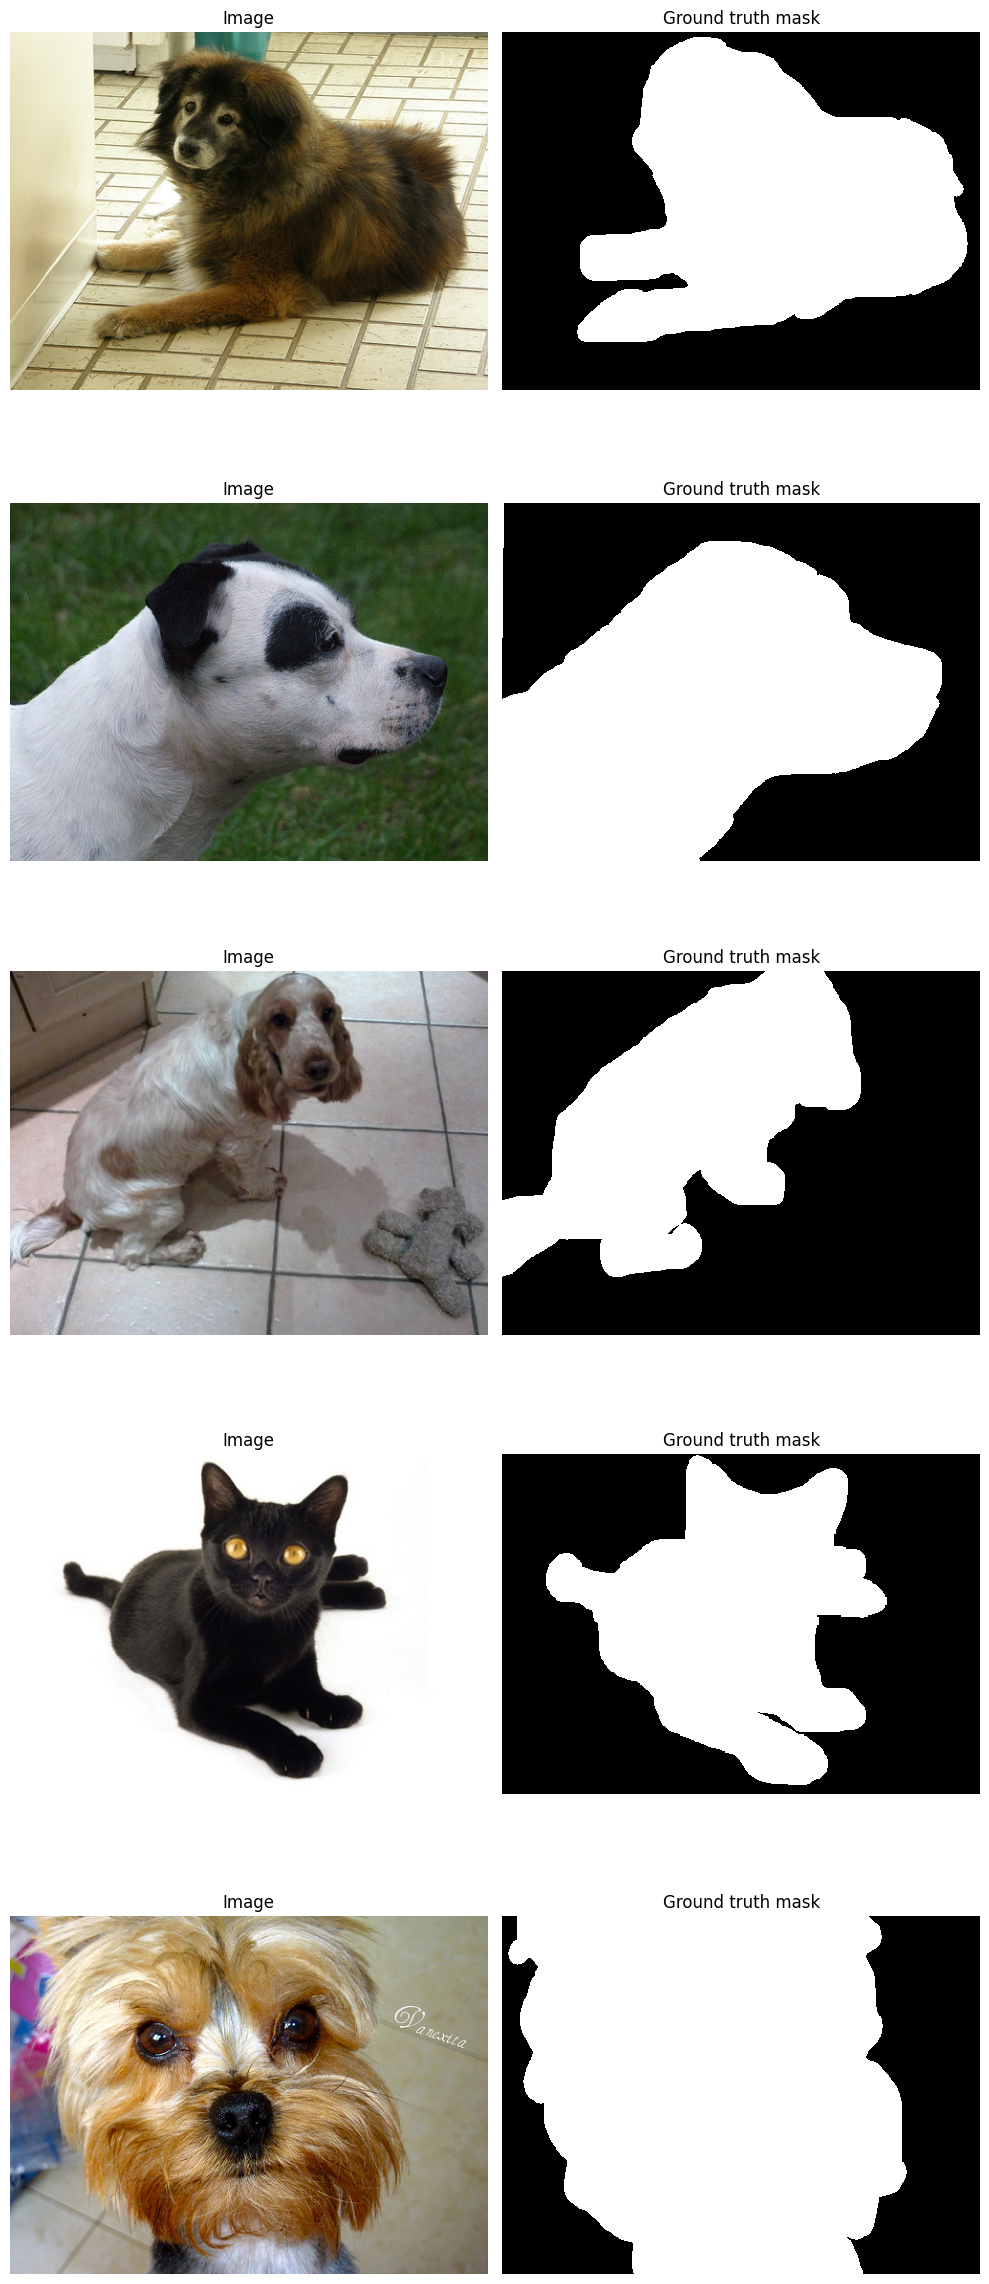

In [7]:
def display_image_grid(images_filenames, images_directory, masks_directory):
    rows = len(images_filenames)
    _, ax = plt.subplots(nrows=rows, ncols=2, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap='gray')

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

    plt.tight_layout()
    plt.show()

display_image_grid(train_images_filenames[:5], images_directory, masks_directory)

## Define Dataset

In [7]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]

        # Read image
        image = cv2.imread(os.path.join(self.images_directory, image_filename))

        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize image into 0-1 range
        # Note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        # Read mask
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )

        # Preprocess mask by converting it into a binary mask
        mask = preprocess_mask(mask)

        # Apply the same data augmentation to both input image and target mask
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image.float(), mask.to(torch.int64)

Define hyperparameters

In [8]:
nr_classes = 2 # background vs foreground/pet
batch_size = 4
num_workers = 0
num_epochs = 10
learning_rate = 1e-4

# Get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Define transformations to be applied to the images and data loaders

In [9]:
# Define transformations/augmentations to be applied to training data
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        ToTensorV2(),
    ]
)

# Define dataloader for training data
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Define transformations to be applied to validation data
val_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.CenterCrop(224, 224),
        ToTensorV2()
    ]
)

# Define dataloader for validation data
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

## Model

We will use the segmentation network from [https://github.com/milesial/Pytorch-UNet](https://github.com/milesial/Pytorch-UNet).

In [10]:
# Convolutional block - applies two convolutional layers in a row
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Downscaling block - downscales image and applies convolutional block
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Upscaling block - upscales image and applies convolutional block
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


# Final convolutional block - applies convolutional layer
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Segmentation network
class SegmentationNetwork(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(SegmentationNetwork, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Train the model

Start by defining the model, the optimizer, loss and metric to evaluate the model.

In this case, we will use the Jaccard Index (also known as intersection over union) as the metric. Since pytorch does not have this metric implemented, we will use the ```torchmetrics``` package. [Click here](https://lightning.ai/docs/torchmetrics/stable/) to find out more about the metrics available on torchmetrics.

In [11]:
# Create model
model = SegmentationNetwork(n_channels=3,n_classes=nr_classes) 
print(model)

# Put model in GPU
model.to(device)

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 

# Define loss (crossentropy)
loss_fn = nn.CrossEntropyLoss() 

# Define metric (e.g. Jaccard Index, Dice Coefficient, Pixel Accuracy)
metric = JaccardIndex(task="multiclass", num_classes=nr_classes)

SegmentationNetwork(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

Now implement the training cycle corresponding to one epoch.

In [12]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (img, mask) in enumerate(tqdm(dataloader)):
          img, mask = img.to(device), mask.to(device)

          # Compute prediction error
          pred = model(img)
          loss = loss_fn(pred, mask)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.append(final_pred.cpu()) # Append tensors
          labels.append(mask.cpu()) # Append tensors

    preds = torch.cat(preds, dim=0) # Concatenate tensors
    labels = torch.cat(labels, dim=0) # Concatenate tensors


    return total_loss / num_batches, metric(preds,labels)

Train the model for 10 epochs. Do not forget to use the validation set to save the best model at each epoch.

In [13]:
# TODO
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'jaccard': []}
  val_history = {'loss': [], 'jaccard': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_jaccard = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train jaccard: {train_jaccard:.3f}")
      val_loss, val_jaccard = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.3f} \t Val jaccard: {val_jaccard:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["jaccard"].append(train_jaccard)

      val_history["loss"].append(val_loss)
      val_history["jaccard"].append(val_jaccard)

  print("Finished")
  return train_history, val_history

train_history, val_history = train(model, "U-net", num_epochs, train_dataloader, val_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


Train loss: 0.665 	 Train jaccard: 0.418


100%|██████████| 125/125 [00:20<00:00,  5.99it/s]


Val loss: 0.622 	 Val jaccard: 0.477

Epoch 2


100%|██████████| 500/500 [02:30<00:00,  3.31it/s]


Train loss: 0.624 	 Train jaccard: 0.474


100%|██████████| 125/125 [00:15<00:00,  7.91it/s]


Val loss: 0.595 	 Val jaccard: 0.516

Epoch 3


100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


Train loss: 0.609 	 Train jaccard: 0.496


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Val loss: 0.581 	 Val jaccard: 0.527

Epoch 4


100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


Train loss: 0.594 	 Train jaccard: 0.517


100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Val loss: 0.571 	 Val jaccard: 0.530

Epoch 5


100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


Train loss: 0.577 	 Train jaccard: 0.534


100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


Val loss: 0.561 	 Val jaccard: 0.549

Epoch 6


100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


Train loss: 0.566 	 Train jaccard: 0.547


100%|██████████| 125/125 [00:17<00:00,  7.35it/s]


Val loss: 0.533 	 Val jaccard: 0.586

Epoch 7


100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


Train loss: 0.555 	 Train jaccard: 0.559


100%|██████████| 125/125 [00:16<00:00,  7.74it/s]


Val loss: 0.537 	 Val jaccard: 0.564

Epoch 8


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


Train loss: 0.547 	 Train jaccard: 0.568


100%|██████████| 125/125 [00:16<00:00,  7.68it/s]


Val loss: 0.516 	 Val jaccard: 0.597

Epoch 9


100%|██████████| 500/500 [02:38<00:00,  3.16it/s]


Train loss: 0.537 	 Train jaccard: 0.580


100%|██████████| 125/125 [00:16<00:00,  7.58it/s]


Val loss: 0.515 	 Val jaccard: 0.592

Epoch 10


100%|██████████| 500/500 [06:38<00:00,  1.25it/s]


Train loss: 0.524 	 Train jaccard: 0.592


100%|██████████| 125/125 [00:32<00:00,  3.87it/s]


Val loss: 0.486 	 Val jaccard: 0.627
Finished


Plot metrics and loss on training and validation sets obtained during the training process

In [14]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Jaccard Index')
    plt.plot(train_history['jaccard'], label='train')
    plt.plot(val_history['jaccard'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

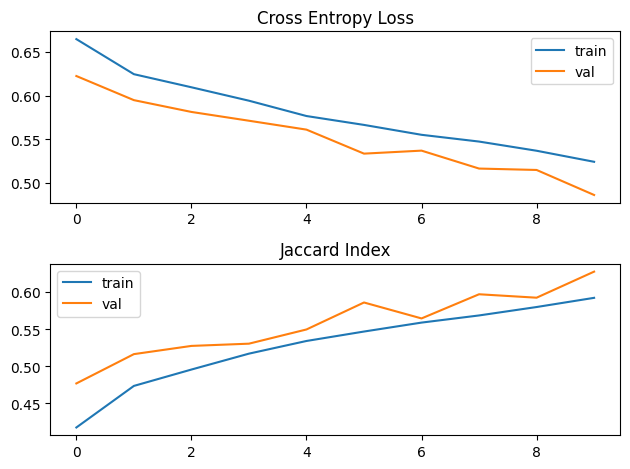

In [15]:
plotTrainingHistory(train_history, val_history)

## Test the model

Visualize the results on only 10 images

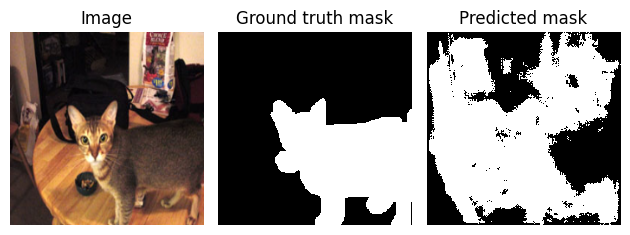

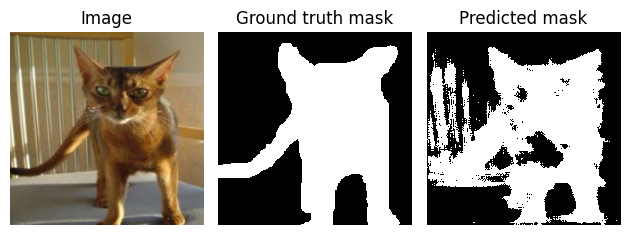

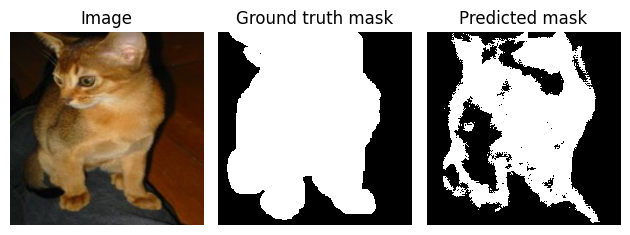

In [16]:
# Load the best model
# TODO
model = SegmentationNetwork(n_channels=3,n_classes=nr_classes).to(device)
checkpoint = torch.load('U-net_best_model.pth')
model.load_state_dict(checkpoint['model'])

# Define test dataloader that loads only 10 images
# inference_transform = # TODO
# inference_dataset = # TODO
# inference_dataloader = # TODO

inference_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.CenterCrop(224, 224),
        ToTensorV2()
    ]
)

inference_dataset = OxfordPetDataset(test_images_filenames[:10], images_directory, masks_directory, transform=inference_transform,)
inference_dataloader = DataLoader(inference_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)


# Visualize the results
with torch.no_grad():
    for img, mask in inference_dataloader:
        img, mask = img.to(device), mask.to(device)

        # Get prediction
        out = model(img)
        probs = F.softmax(out, dim=1)
        pred = torch.argmax(probs, dim=1)

        # Show original image, mask and prediction
        fig, ax = plt.subplots(ncols=3)
        ax[0].imshow(img[0].cpu().numpy().transpose((1, 2, 0)))
        ax[1].imshow(mask[0].cpu().numpy(), interpolation="nearest", cmap='gray')
        ax[2].imshow(pred[0].cpu().numpy(), interpolation="nearest", cmap='gray')

        ax[0].set_title("Image")
        ax[1].set_title("Ground truth mask")
        ax[2].set_title("Predicted mask")

        ax[0].set_axis_off()
        ax[1].set_axis_off()
        ax[2].set_axis_off()

        plt.tight_layout()
        plt.show()
